# ps

> persistent scatterers identification

In [ ]:
#| default_exp cli/ps

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import zarr
import numpy as np
from matplotlib import pyplot as plt
import colorcet
import moraine.cli as mc
from moraine.utils_ import is_cuda_available

In [ ]:
#| export
import logging
import zarr
import time
import numpy as np

import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster, progress
from moraine.utils_ import is_cuda_available
if is_cuda_available():
    import cupy as cp
    from dask_cuda import LocalCUDACluster
    from rmm.allocators.cupy import rmm_cupy_allocator
import moraine as mr
from moraine.cli.logging import mc_logger
from moraine.cli import dask_from_zarr, dask_to_zarr

In [ ]:
#| export
@mc_logger
def amp_disp(
    rslc:str, # rslc stack
    adi:str, #output, amplitude dispersion index
    chunks:tuple[int,int]=None, # data processing chunk size, same as rslc by default
    out_chunks:tuple[int,int]=None, # output data chunk size, same as chunks by default
    cuda:bool=False, # if use cuda for processing, false by default
    processes=None, # use process for dask worker over thread, the default is False for cpu, only applied if cuda==False
    n_workers=None, # number of dask worker, the default is 1 for cpu, number of GPU for cuda
    threads_per_worker=None, # number of threads per dask worker, the default is 1 for cpu, only applied if cuda==False
    rmm_pool_size=0.9, # set the rmm pool size, only applied when cuda==True
    **dask_cluster_arg, # other dask local/cudalocal cluster args
):
    '''calculation the amplitude dispersion index from SLC stack.'''
    rslc_path = rslc
    adi_path = adi
    logger = logging.getLogger(__name__)
    rslc_zarr = zarr.open(rslc_path,mode='r')
    logger.zarr_info(rslc_path,rslc_zarr)
    if chunks is None: chunks = rslc_zarr.chunks[:2]
    if out_chunks is None: out_chunks = chunks
    if cuda:
        Cluster = LocalCUDACluster; cluster_args= {
            'n_workers':n_workers,
            'rmm_pool_size':rmm_pool_size}
        cluster_args.update(dask_cluster_arg)
        xp = cp
    else:
        if processes is None: processes = False
        if n_workers is None: n_workers = 1
        if threads_per_worker is None: threads_per_worker = 1
        Cluster = LocalCluster; cluster_args = {'processes':processes, 'n_workers':n_workers, 'threads_per_worker':threads_per_worker}
        cluster_args.update(dask_cluster_arg)
        xp = np

    logger.info('starting dask local cluster.')
    with Cluster(**cluster_args) as cluster, Client(cluster) as client:
        if cuda:
            client.run(cp.cuda.set_allocator, rmm_cupy_allocator)
        logger.info('dask local cluster started.')
        logger.dask_cluster_info(cluster)

        cpu_rslc = dask_from_zarr(rslc_path,chunks=(*chunks,*rslc_zarr.shape[2:]))
        logger.darr_info('rslc', cpu_rslc)
        logger.info(f'calculate amplitude dispersion index.')
        rslc = cpu_rslc.map_blocks(cp.asarray) if cuda else cpu_rslc
        rslc_delayed = rslc.to_delayed()
        adi_delayed = np.empty_like(rslc_delayed,dtype=object)
        with np.nditer(rslc_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as it:
            for block in it:
                idx = it.multi_index
                adi_delayed[idx] = delayed(mr.amp_disp,pure=True,nout=1)(rslc_delayed[idx])
                adi_delayed[idx] =da.from_delayed(adi_delayed[idx],shape=rslc.blocks[idx].shape[0:2],meta=xp.array((),dtype=xp.float32))
        adi = da.block(adi_delayed[...,0].tolist())
        
        logger.info(f'got amplitude dispersion index.')
        logger.darr_info('adi', adi)

        cpu_adi = adi.map_blocks(cp.asnumpy) if cuda else adi
        logger.darr_info('adi', cpu_adi)
        logger.info('saving adi.')
        _adi = dask_to_zarr(cpu_adi,adi_path,chunks=out_chunks)
        # _adi = da.to_zarr(cpu_adi,adi_path,compute=False,overwrite=True)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_adi)
        progress(futures,notebook=False)
        time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

Using amplitude dispersion index (ADI) to identify persistent scatterers is first used in [@ferrettiPermanentScatterersSAR2001].

Usage:

In [ ]:
rslc = './raw/rslc.zarr'
adi = './ps/adi.zarr'

In [ ]:
logger = mc.get_logger()

In [ ]:
amp_disp(rslc,adi)

2025-09-18 12:30:08 - log_args - INFO - running function: amp_disp
2025-09-18 12:30:08 - log_args - INFO - fetching args:
2025-09-18 12:30:08 - log_args - INFO - rslc = './raw/rslc.zarr'
2025-09-18 12:30:08 - log_args - INFO - adi = './ps/adi.zarr'
2025-09-18 12:30:08 - log_args - INFO - chunks = None
2025-09-18 12:30:08 - log_args - INFO - out_chunks = None
2025-09-18 12:30:08 - log_args - INFO - cuda = False
2025-09-18 12:30:08 - log_args - INFO - processes = None
2025-09-18 12:30:08 - log_args - INFO - n_workers = None
2025-09-18 12:30:08 - log_args - INFO - threads_per_worker = None
2025-09-18 12:30:08 - log_args - INFO - rmm_pool_size = 0.9
2025-09-18 12:30:08 - log_args - INFO - dask_cluster_arg = {}
2025-09-18 12:30:08 - log_args - INFO - fetching args done.
2025-09-18 12:30:08 - zarr_info - INFO - ./raw/rslc.zarr zarray shape, chunks, dtype: (2500, 1834, 17), (1000, 1000, 1), complex64
2025-09-18 12:30:08 - amp_disp - INFO - starting dask local cluster.
2025-09-18 12:30:10 - am

In [ ]:
if is_cuda_available:
    amp_disp(rslc,adi,cuda=True)

2025-09-18 12:30:12 - log_args - INFO - running function: amp_disp
2025-09-18 12:30:12 - log_args - INFO - fetching args:
2025-09-18 12:30:12 - log_args - INFO - rslc = './raw/rslc.zarr'
2025-09-18 12:30:12 - log_args - INFO - adi = './ps/adi.zarr'
2025-09-18 12:30:12 - log_args - INFO - chunks = None
2025-09-18 12:30:12 - log_args - INFO - out_chunks = None
2025-09-18 12:30:12 - log_args - INFO - cuda = True
2025-09-18 12:30:12 - log_args - INFO - processes = None
2025-09-18 12:30:12 - log_args - INFO - n_workers = None
2025-09-18 12:30:12 - log_args - INFO - threads_per_worker = None
2025-09-18 12:30:12 - log_args - INFO - rmm_pool_size = 0.9
2025-09-18 12:30:12 - log_args - INFO - dask_cluster_arg = {}
2025-09-18 12:30:12 - log_args - INFO - fetching args done.
2025-09-18 12:30:12 - zarr_info - INFO - ./raw/rslc.zarr zarray shape, chunks, dtype: (2500, 1834, 17), (1000, 1000, 1), complex64
2025-09-18 12:30:12 - amp_disp - INFO - starting dask local cluster.


2025-09-18 12:30:14,589 - distributed.worker - WARNING - Setting CPU affinity for GPU failed. Please refer to the following link for troubleshooting information: https://docs.rapids.ai/api/dask-cuda/nightly/troubleshooting/#setting-cpu-affinity-failure
2025-09-18 12:30:14,600 - distributed.worker - WARNING - Setting CPU affinity for GPU failed. Please refer to the following link for troubleshooting information: https://docs.rapids.ai/api/dask-cuda/nightly/troubleshooting/#setting-cpu-affinity-failure


2025-09-18 12:30:15 - amp_disp - INFO - dask local cluster started.
2025-09-18 12:30:15 - dask_cluster_info - INFO - dask cluster: LocalCUDACluster(dashboard_link='http://127.0.0.1:8787/status', workers=2, threads=2, memory=256.00 GiB)
2025-09-18 12:30:15 - darr_info - INFO - rslc dask array shape, chunksize, dtype: (2500, 1834, 17), (1000, 1000, 17), complex64
2025-09-18 12:30:15 - amp_disp - INFO - calculate amplitude dispersion index.
2025-09-18 12:30:15 - amp_disp - INFO - got amplitude dispersion index.
2025-09-18 12:30:15 - darr_info - INFO - adi dask array shape, chunksize, dtype: (2500, 1834), (1000, 1000), float32
2025-09-18 12:30:15 - darr_info - INFO - adi dask array shape, chunksize, dtype: (2500, 1834), (1000, 1000), float32
2025-09-18 12:30:15 - amp_disp - INFO - saving adi.
2025-09-18 12:30:15 - zarr_info - INFO - ./ps/adi.zarr zarray shape, chunks, dtype: (2500, 1834), (1000, 1000), float32
2025-09-18 12:30:15 - amp_disp - INFO - computing graph setted. doing all the co

In [ ]:
adi = zarr.open('./ps/adi.zarr/',mode='r')[:]

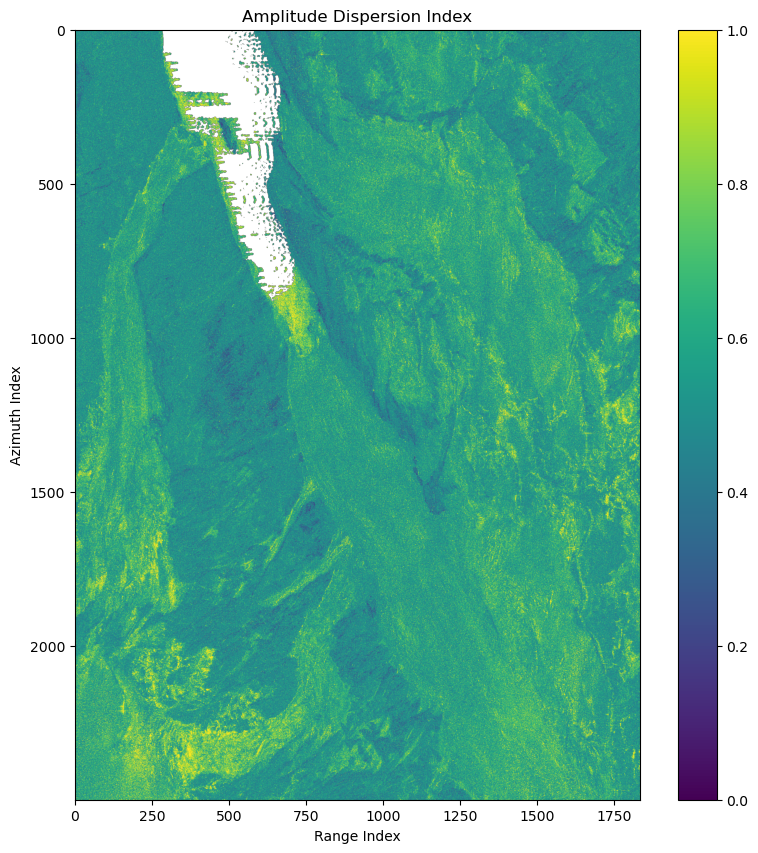

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(adi,vmin=0,vmax=1)
ax.set(title='Amplitude Dispersion Index',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

We can then select PS candidate according to adi:

In [ ]:
ps_can_gix = './ps/ps_can_gix.zarr'
mc.pc_logic_ras('./ps/adi.zarr/',ps_can_gix,'(ras>=0)&(ras<=0.3)')
mc.ras2pc(
    ps_can_gix, 
    ['raw/rslc.zarr', 'ps/adi.zarr',  'transform/e.zarr', 'transform/n.zarr'],
    ['ps/ps_can_rslc.zarr', 'ps/ps_can_adi.zarr',  'ps/ps_can_e.zarr', 'ps/ps_can_n.zarr'],
)

2025-09-18 12:30:19 - log_args - INFO - running function: pc_logic_ras
2025-09-18 12:30:19 - log_args - INFO - fetching args:
2025-09-18 12:30:19 - log_args - INFO - ras = './ps/adi.zarr/'
2025-09-18 12:30:19 - log_args - INFO - gix = './ps/ps_can_gix.zarr'
2025-09-18 12:30:19 - log_args - INFO - operation = '(ras>=0)&(ras<=0.3)'
2025-09-18 12:30:19 - log_args - INFO - chunks = 100000
2025-09-18 12:30:19 - log_args - INFO - fetching args done.
2025-09-18 12:30:19 - zarr_info - INFO - ./ps/adi.zarr/ zarray shape, chunks, dtype: (2500, 1834), (1000, 1000), float32
2025-09-18 12:30:19 - pc_logic_ras - INFO - loading ras into memory.
2025-09-18 12:30:19 - pc_logic_ras - INFO - select pc based on operation: (ras>=0)&(ras<=0.3)
2025-09-18 12:30:19 - pc_logic_ras - INFO - number of selected pixels: 43201.
2025-09-18 12:30:19 - zarr_info - INFO - ./ps/ps_can_gix.zarr zarray shape, chunks, dtype: (43201, 2), (100000, 1), int32
2025-09-18 12:30:19 - pc_logic_ras - INFO - writing gix.
2025-09-18 

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()